In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm

from astroML.correlation import two_point, bootstrap_two_point

from astropy.table import Table

import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
# from exoplanetarchive.ipac.caltech.edu
Efile = 'planets_2019.04.22_15.27.57.csv'

df = pd.read_csv(Efile, comment='#')
df.columns

Index(['pl_hostname', 'pl_letter', 'pl_name', 'pl_discmethod',
       'pl_controvflag', 'pl_pnum', 'pl_orbper', 'pl_orbpererr1',
       'pl_orbpererr2', 'pl_orbperlim', 'pl_orbsmax', 'pl_orbsmaxerr1',
       'pl_orbsmaxerr2', 'pl_orbsmaxlim', 'pl_orbeccen', 'pl_orbeccenerr1',
       'pl_orbeccenerr2', 'pl_orbeccenlim', 'pl_orbincl', 'pl_orbinclerr1',
       'pl_orbinclerr2', 'pl_orbincllim', 'pl_bmassj', 'pl_bmassjerr1',
       'pl_bmassjerr2', 'pl_bmassjlim', 'pl_bmassprov', 'pl_radj',
       'pl_radjerr1', 'pl_radjerr2', 'pl_radjlim', 'pl_dens', 'pl_denserr1',
       'pl_denserr2', 'pl_denslim', 'pl_ttvflag', 'pl_kepflag', 'pl_k2flag',
       'pl_nnotes', 'ra_str', 'ra', 'dec_str', 'dec', 'st_dist', 'st_disterr1',
       'st_disterr2', 'st_distlim', 'st_optmag', 'st_optmagerr',
       'st_optmaglim', 'st_optband', 'gaia_gmag', 'gaia_gmagerr',
       'gaia_gmaglim', 'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_tefflim',
       'st_mass', 'st_masserr1', 'st_masserr2', 'st_masslim', 'st

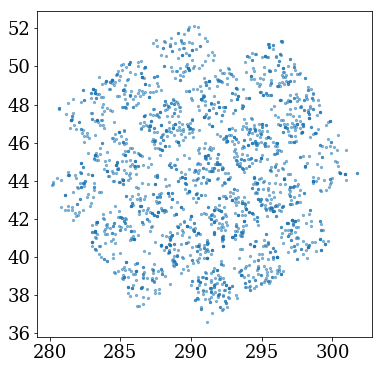

In [4]:
Kok = np.where((df['ra'] > 200) & (df['dec'] > 20))[0]

plt.figure(figsize=(6,6))
plt.scatter(df['ra'][Kok], df['dec'][Kok], s=5, alpha=0.5)

Text(0, 0.5, 'Fraction of Systems')

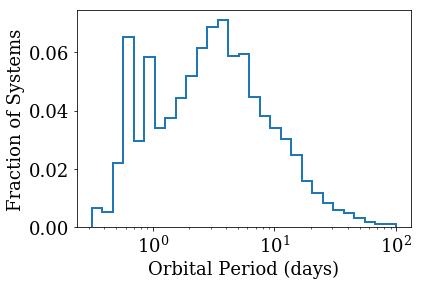

In [46]:
hh, bb, _ = plt.hist(df['pl_orbper'], bins=np.logspace(-0.5,2,30), normed=True, 
                     histtype='step', lw=2)
plt.xscale('log')
plt.xlabel('Orbital Period (days)')
plt.ylabel('Fraction of Systems')

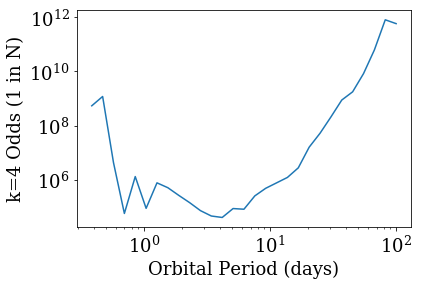

In [48]:
plt.plot(bb[1:], 1/(hh**4))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Orbital Period (days)')
plt.ylabel('k=4 Odds (1 in N)')
plt.savefig('../figures/k4odds.pdf', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [ ]:
k=4 

# now loop over every exoplanet

# measure "sameness" of orbital period for itself & 3 nearest (geometric distance?)

# Q: how to really get this sameness thing....?

